<br>

# EDA Linear Array

<br>

## environmental

<br>

In [1]:
#load methods
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

In [2]:
#load .mat into python environment
linArrayPath = "/home/bonzilla/Documents/smilodonCub_fossils/MATLAB/linArrayWorkspace.mat"
linArrayMat = loadmat( linArrayPath )

In [3]:
print( type( linArrayMat ) )
linArrayMat.keys()

<class 'dict'>


dict_keys(['__header__', '__version__', '__globals__', 'FP09', 'FP09_ind', 'FP09_ts', 'FP09_ts_step', 'FP10', 'FP10_ind', 'FP10_ts', 'FP10_ts_step', 'FP11', 'FP11_ind', 'FP11_ts', 'FP11_ts_step', 'FP12', 'FP12_ind', 'FP12_ts', 'FP12_ts_step', 'FP13', 'FP13_ind', 'FP13_ts', 'FP13_ts_step', 'FP14', 'FP14_ind', 'FP14_ts', 'FP14_ts_step', 'FP15', 'FP15_ind', 'FP15_ts', 'FP15_ts_step', 'FP16', 'FP16_ind', 'FP16_ts', 'FP16_ts_step', 'SPK09a', 'SPK09i', 'SPK10a', 'SPK10i', 'SPK11a', 'SPK11i', 'SPK12i', 'SPK13a', 'SPK13i', 'SPK14a', 'SPK14i', 'SPK15a', 'SPK15i', 'SPK16a', 'SPK16i', 'Start', 'Stop', 'Strobed00001', 'Strobed00003', 'Strobed00005', 'Strobed00006', 'Strobed00007', 'Strobed00009', 'Strobed00010', 'Strobed00013', 'Strobed00014', 'Strobed00016', 'Strobed00017', 'Strobed00018', 'Strobed00030', 'Strobed00040', 'Strobed00041', 'Strobed00043', 'Strobed00046', 'Strobed00050', 'Strobed00100', 'Strobed00102', 'Strobed00131', 'Strobed00161', 'Strobed00235', 'Strobed00360', 'Strobed00400', 'S

<br>

## reshape mat struct

reshape the imported matlab structure tosomethng more pythonic  
the matlab struct for the linear array is imported by `loadmat()` as a python dictionary. to facilitate further analysis, we will massage the data into a more workable form as a pandas dataframe...

<br>

### understand the dictionary fields

<br>

In [4]:
# the delayedSaccIntervals field
delayedSaccade_dat = linArrayMat[ 'delayedSaccIntervals' ]
delayedSaccade_DF = pd.DataFrame( data = delayedSaccade_dat, columns = [ 'start','end' ] )
delayedSaccade_DF.head()

,start,end
0,0.000,21.2835
1,21.832,24.9940
2,25.436,28.7080
3,29.250,32.3125
4,32.854,36.1360


In [5]:
# the catSearchPHYSIOLIntervals feld
catSearchPHYSIOL_dat = linArrayMat[ 'catSearchPHYSIOLIntervals' ]
catSearchPHYSIOL_DF = pd.DataFrame( data = catSearchPHYSIOL_dat, columns = [ 'start','end' ] )
catSearchPHYSIOL_DF.head()

,start,end
0,362.9720,366.9035
1,367.4555,370.5080
2,371.0595,374.5520
3,375.0975,378.5905
4,379.1320,383.3935


In [6]:
# spiking data for channel 9
spike09_dat = linArrayMat[ 'SPK09a' ]
print( len( spike09_dat ) )
print( spike09_dat[0:10], )

18737
[[0.064 ]
 [0.19  ]
 [0.2495]
 [0.5405]
 [0.5545]
 [0.582 ]
 [0.634 ]
 [0.7025]
 [1.082 ]
 [1.3005]]


In [7]:
# field potnetial data for channel 9
FP09_dat = linArrayMat[ 'FP09' ]
print( len( FP09_dat ) )
print( FP09_dat[0:10] )

980450
[[ 0.00288222]
 [-0.0024075 ]
 [-0.00837538]
 [-0.00613742]
 [-0.00891791]
 [-0.01322428]
 [-0.01698812]
 [-0.01946343]
 [-0.02088759]
 [-0.02034505]]


In [8]:
# a dataframe that holds columns names for all channels with spike data    
allKeys = pd.DataFrame( linArrayMat.keys(), columns = [ 'channels' ] )
spikeKeys_IDX = allKeys['channels'].str.startswith( 'SPK' )
spikeKeys = allKeys[ spikeKeys_IDX ]
print( len( spikeKeys ) )
spikeKeys.head()

15


,channels
35,SPK09a
36,SPK09i
37,SPK10a
38,SPK10i
39,SPK11a


In [9]:
# some helper functions to help format the linear array dictionary
def getStartEndTimestanps( array_DF, task ):
    """
    return the trial start and end timestamps for a task
    """
    task_dat = array_DF[ task ]
    task_DF = pd.DataFrame( data = task_dat, 
                           columns = [ 'start','end' ] )
    return task_DF

def formatStrobedEventSTR( eventmarker_int ):
    #make a string for the strobed event column label
    numZeros = 12 - 7 - len( str( eventmarker_int ) )
    strobedLabel = 'Strobed' + '0'*numZeros + str( eventmarker_int )
    return strobedLabel

def getChannelTrialData( array_DF, task, channel ):
    """
    generates a list for each trial within a pandas series for a specific task.
    array_DF: pandas dataframe with array data
    task: string for task batched data intervals
    channel: string for a plexon channel (e.g. SPK or FP)
    returns a pandas series of lists for trial data of a given channel
    """
    # a DF of all the spike timestamps for `channel`
    channelDat = array_DF[ channel ]
    channelDat_DF = pd.DataFrame( data = channelDat, 
                                 columns = [ 'timestamps' ] )
    # a DF for all the start/stop timestamps for each trial for `task`
    task_DF = getStartEndTimestanps( array_DF, task )
    numTrials = len( task_DF[ 'start' ] )
    timeStampLists = pd.Series([], dtype= 'float64')
    
    #for each trial, get the spike timestamps inbetween the trial
    #start/end and format as a list
    for aTrial in range( numTrials ):
        startTime = task_DF[ 'start' ][ aTrial ]
        endTime = task_DF[ 'end' ][ aTrial ]
        trialTimeStamps_IDX = channelDat_DF[ 'timestamps' ].between( startTime, endTime )
        trialTimeStamps = channelDat_DF[ trialTimeStamps_IDX ]
        listoflists_TS = trialTimeStamps.values.tolist()  
        timeStampLists[ aTrial ] = [item for sublist in listoflists_TS for item in sublist]
    # return a pandas.core.series.Series where each field is a list
    # of spike timestamps for each trial of task for a given channel
    return timeStampLists

def getDataTypeNames( array_DF, neuralDatType ):
    """
    returns a pandas dataframe with a feature of strings, one for each 
    plexon channel to be collected on
    array_DF: pandas dataframe with array data
    neuralDatType: (string) either 'SPK' or 'FP'. error is thrown for other values
    """
    allKeys = pd.DataFrame( array_DF.keys(), columns = [ 'channels' ] )
    typeKeys_IDX = allKeys['channels'].str.startswith( neuralDatType )
    dataTypeNames = allKeys[ typeKeys_IDX ]
    return dataTypeNames


def getMultiChannelTrialData( array_DF, dataType, task ):
    """
    given data and a specific task, returns a dataframe with a row for each 
    trial a feature for start and end timestamps and features for each channel 
    queried. channel features hold a list of data (e.g. spikes) for each trial
    array_DF: pandas dataframe with array data
    dataType: (string) SPK or FP 
    plexon channel to be collected on
    task: string for task batched data intervals
    """
    selectData_df = getDataTypeNames( array_DF, dataType )
    task_DF = getStartEndTimestanps( array_DF, task )

    #for each item in channel_df:
    for aChannel in range( len( selectData_df ) ):    
        #getTrialTimestamps
        channel = selectData_df[ 'channels' ].values[ aChannel ]
        channelTrialDat = getChannelTrialData( array_DF, task, channel )
        #print( type( channelTrialDat ) )
        task_DF[ channel ] = channelTrialDat
        #add as a new feature to trialDat_DF
    return task_DF

def addEventMarker( array_DF, task_DF, eventmarkers, task ):
    """
    takes in array dataframe and finds the timestamps for a specified
    eventmarker for each trial to be added as a feature column to a 
    dataframe of trial data (i.e. output from getMultiChannelTimestamps())
    array_DF: pandas dataframe generated from a matlab structure summarizing array data
    trialDat_DF: pandas dataframe with data by trial (output from getMultiChannelTrialData())
    eventmarker: int, specifies which eventmarker to parse from array_DF
    """
    
    for eventmarker in eventmarkers:
        #make a string for the strobed event column label
        strobedLabel = formatStrobedEventSTR( eventmarker )

        #check that the eventmarker is present
        colNames = pd.DataFrame( array_DF.keys(), columns = [ 'keys' ] )
        if colNames[ 'keys' ].str.contains( strobedLabel ).any():
            taskEventMarkers = getChannelTrialData( array_DF, task, strobedLabel )
        else:
            raise Exception( 'Sorry, eventmarker not present\nbe sure to enter \
                        only the integer value of the event\nex: CORRECT: 14 \
                        INCORRECT: 00014, Strobed00014')
        task_DF[ strobedLabel ] = taskEventMarkers    
    return task_DF

In [10]:
# demonstrate getChannelTrialData()
# generates a pandas series witha row for each trial holding a list of spike times
SPK09a_spikedat = getChannelTrialData( linArrayMat, 'delayedSaccIntervals', 'SPK09a')
SPK09a_spikedat[0:5]

0    [0.064, 0.19, 0.2495, 0.5405, 0.5545, 0.582, 0...
1    [21.9155, 22.0605, 22.519, 22.8845, 22.9575, 2...
2    [25.9435, 26.0485, 26.1345, 26.1595, 26.534, 2...
3    [29.518, 29.954, 30.0885, 30.2455, 30.3545, 30...
4    [32.897, 32.9765, 33.289, 33.5505, 33.6065, 33...
dtype: object

In [11]:
# demonstrate getMultiChannelTrialData()
# generates a pandas dataframe with a row for each trial, start/end features and columns for each channeldata
dSacctrials = getMultiChannelTrialData( linArrayMat, 'SPK', 'delayedSaccIntervals' )
dSacctrials.head()

,start,end,SPK09a,SPK09i,SPK10a,SPK10i,SPK11a,SPK11i,SPK12i,SPK13a,SPK13i,SPK14a,SPK14i,SPK15a,SPK15i,SPK16a,SPK16i
0,0.000,21.2835,"[0.064, 0.19, 0.2495, 0.5405, 0.5545, 0.582, 0...","[0.013, 0.0145, 0.1245, 0.153, 0.448, 0.848, 2...","[0.487, 1.238, 1.4395, 1.45, 1.588, 1.667, 1.9...","[5.6615, 12.6, 18.806, 18.813]","[0.003, 0.011, 0.013, 0.017, 0.019, 0.0265, 0....","[0.0235, 0.028, 0.051, 0.067, 0.0915, 0.1115, ...","[0.0005, 0.001, 0.003, 0.011, 0.0155, 0.0235, ...",[],"[0.001, 0.006, 0.009, 0.01, 0.013, 0.0145, 0.0...","[0.003, 0.0075, 0.0105, 0.019, 0.0265, 0.0325,...","[0.0025, 0.0055, 0.0365, 0.068, 0.118, 0.1815,...","[0.303, 0.347, 2.087, 2.578, 2.756, 8.532, 8.5...",[],"[0.004, 0.0065, 0.0075, 0.0365, 0.037, 0.045, ...",[]
1,21.832,24.9940,"[21.9155, 22.0605, 22.519, 22.8845, 22.9575, 2...","[21.858, 22.4455, 22.758, 22.809, 23.343, 23.3...","[22.436, 22.438, 22.4405, 22.445, 22.448, 22.4...",[],"[21.8505, 21.8895, 21.895, 21.9085, 21.911, 21...","[21.844, 21.874, 21.9035, 21.9355, 21.961, 22....","[21.8325, 21.838, 21.841, 21.8415, 21.8435, 21...",[],"[21.867, 21.898, 21.922, 21.997, 22.2705, 22.3...","[21.844, 21.8695, 21.924, 21.9515, 21.9625, 22...","[21.8755, 22.002, 22.425, 22.4285, 22.4295, 22...","[22.478, 22.692, 22.7295, 23.142, 23.153, 23.1...","[23.009, 23.197]","[21.932, 22.0095, 22.0405, 22.089, 22.159, 22....",[]
2,25.436,28.7080,"[25.9435, 26.0485, 26.1345, 26.1595, 26.534, 2...","[26.0355, 26.1315, 26.2155, 26.4875, 26.877, 2...","[25.5225, 25.5685, 25.9695, 26.1285, 26.1315, ...","[26.1435, 27.094, 27.097]","[25.496, 25.508, 25.5145, 25.516, 25.5195, 25....","[25.473, 25.493, 25.5355, 25.559, 25.5605, 26....","[25.4385, 25.448, 25.454, 25.4575, 25.46, 25.4...",[],"[25.493, 25.517, 25.533, 25.536, 25.537, 25.54...","[25.4475, 25.645, 25.649, 25.6595, 25.73, 25.7...","[25.503, 25.6845, 25.89, 26.0285, 26.0755, 26....","[26.3605, 26.3815, 26.5835, 26.667, 26.6855, 2...",[],"[25.6065, 25.6455, 25.6525, 25.6895, 25.7195, ...",[]
3,29.250,32.3125,"[29.518, 29.954, 30.0885, 30.2455, 30.3545, 30...","[29.9335, 29.9395, 30.771, 30.801, 31.0955, 31...","[29.9335, 29.95, 29.9555, 30.0295, 30.1905, 30...",[],"[29.252, 29.2625, 29.27, 29.272, 29.275, 29.31...","[29.258, 29.2655, 29.274, 29.3615, 29.3645, 29...","[29.2515, 29.2525, 29.253, 29.2555, 29.258, 29...",[],"[29.252, 29.2565, 29.376, 29.4095, 29.4155, 29...","[29.252, 29.2535, 29.266, 29.3385, 29.417, 29....","[29.2505, 29.255, 29.2565, 29.2585, 29.2605, 2...","[30.2355, 30.4665, 30.4985, 30.51, 30.536, 30....",[],"[29.254, 29.26, 29.263, 29.3215, 29.3525, 29.4...",[29.9425]
4,32.854,36.1360,"[32.897, 32.9765, 33.289, 33.5505, 33.6065, 33...","[32.9485, 33.5995, 33.7015, 33.9385, 34.5225, ...","[32.863, 32.945, 32.9635, 33.595, 33.597, 33.6...",[33.6065],"[32.8595, 32.867, 32.878, 32.8795, 32.8805, 32...","[32.8835, 32.888, 32.925, 32.9255, 32.9395, 32...","[32.8555, 32.857, 32.858, 32.859, 32.864, 32.8...",[],"[32.8735, 32.876, 32.896, 32.904, 32.9075, 32....","[32.886, 32.887, 32.896, 32.904, 32.911, 32.95...","[32.9315, 32.9405, 32.9485, 32.9875, 33.4255, ...","[33.658, 33.867, 34.013, 34.0425, 34.092, 34.2...",[],"[32.8765, 32.907, 32.9215, 32.945, 32.9875, 33...",[33.6075]


In [12]:
addStrobes = dSacctrials.copy()
addEventMarker( linArrayMat, addStrobes, [1, 30, 40, 666, 100, 2018], 'delayedSaccIntervals' )
addStrobes.head()

,start,end,SPK09a,SPK09i,SPK10a,SPK10i,SPK11a,SPK11i,SPK12i,SPK13a,...,SPK15a,SPK15i,SPK16a,SPK16i,Strobed00001,Strobed00030,Strobed00040,Strobed00666,Strobed00100,Strobed02018
0,0.000,21.2835,"[0.064, 0.19, 0.2495, 0.5405, 0.5545, 0.582, 0...","[0.013, 0.0145, 0.1245, 0.153, 0.448, 0.848, 2...","[0.487, 1.238, 1.4395, 1.45, 1.588, 1.667, 1.9...","[5.6615, 12.6, 18.806, 18.813]","[0.003, 0.011, 0.013, 0.017, 0.019, 0.0265, 0....","[0.0235, 0.028, 0.051, 0.067, 0.0915, 0.1115, ...","[0.0005, 0.001, 0.003, 0.011, 0.0155, 0.0235, ...",[],...,"[0.303, 0.347, 2.087, 2.578, 2.756, 8.532, 8.5...",[],"[0.004, 0.0065, 0.0075, 0.0365, 0.037, 0.045, ...",[],[17.961],[18.7475],[19.306],[19.8995],[20.949],[17.8095]
1,21.832,24.9940,"[21.9155, 22.0605, 22.519, 22.8845, 22.9575, 2...","[21.858, 22.4455, 22.758, 22.809, 23.343, 23.3...","[22.436, 22.438, 22.4405, 22.445, 22.448, 22.4...",[],"[21.8505, 21.8895, 21.895, 21.9085, 21.911, 21...","[21.844, 21.874, 21.9035, 21.9355, 21.961, 22....","[21.8325, 21.838, 21.841, 21.8415, 21.8435, 21...",[],...,"[22.478, 22.692, 22.7295, 23.142, 23.153, 23.1...","[23.009, 23.197]","[21.932, 22.0095, 22.0405, 22.089, 22.159, 22....",[],[],[22.3725],[23.0395],[23.6325],[24.6655],[]
2,25.436,28.7080,"[25.9435, 26.0485, 26.1345, 26.1595, 26.534, 2...","[26.0355, 26.1315, 26.2155, 26.4875, 26.877, 2...","[25.5225, 25.5685, 25.9695, 26.1285, 26.1315, ...","[26.1435, 27.094, 27.097]","[25.496, 25.508, 25.5145, 25.516, 25.5195, 25....","[25.473, 25.493, 25.5355, 25.559, 25.5605, 26....","[25.4385, 25.448, 25.454, 25.4575, 25.46, 25.4...",[],...,"[26.3605, 26.3815, 26.5835, 26.667, 26.6855, 2...",[],"[25.6065, 25.6455, 25.6525, 25.6895, 25.7195, ...",[],[25.4545],[26.064],[26.581],[27.383],[28.432],[]
3,29.250,32.3125,"[29.518, 29.954, 30.0885, 30.2455, 30.3545, 30...","[29.9335, 29.9395, 30.771, 30.801, 31.0955, 31...","[29.9335, 29.95, 29.9555, 30.0295, 30.1905, 30...",[],"[29.252, 29.2625, 29.27, 29.272, 29.275, 29.31...","[29.258, 29.2655, 29.274, 29.3615, 29.3645, 29...","[29.2515, 29.2525, 29.253, 29.2555, 29.258, 29...",[],...,"[30.2355, 30.4665, 30.4985, 30.51, 30.536, 30....",[],"[29.254, 29.26, 29.263, 29.3215, 29.3525, 29.4...",[29.9425],[],[29.881],[30.3975],[31.0155],[32.057],[]
4,32.854,36.1360,"[32.897, 32.9765, 33.289, 33.5505, 33.6065, 33...","[32.9485, 33.5995, 33.7015, 33.9385, 34.5225, ...","[32.863, 32.945, 32.9635, 33.595, 33.597, 33.6...",[33.6065],"[32.8595, 32.867, 32.878, 32.8795, 32.8805, 32...","[32.8835, 32.888, 32.925, 32.9255, 32.9395, 32...","[32.8555, 32.857, 32.858, 32.859, 32.864, 32.8...",[],...,"[33.658, 33.867, 34.013, 34.0425, 34.092, 34.2...",[],"[32.8765, 32.907, 32.9215, 32.945, 32.9875, 33...",[33.6075],[],[33.539],[34.2055],[34.815],[35.848],[]


<br>

### Aligning Neural Data by Stimulus Onset

align the data by stimulus onset. This requires knowing the MonkeyLogic eventmarker for the stimulus onset. Can also be used for any other eventmarker 

<br>

In [13]:
stimOn = 30 #define the eventmarker for stimulus onset

# define a function to adjust timestamps by stimulus onset
def addStimOnset( data_df, stimOnset_eventmarker, dataType ):
    """
    returns an array with neual data adjusted for the stimulus onset time
    data_df, stimOnset_eventmarker, dataType
    """
    adjustdata_df = data_df.copy()
    
    #make a string for the strobed event column label
    strobedLabel = formatStrobedEventSTR( stimOnset_eventmarker )
    #print( strobedLabel )
    
    #make a list of data columns to adjust
    columns2adjust = getDataTypeNames( data_df, dataType )
    columns2adjust = columns2adjust.values.tolist() 
    columns2adjust = [item for sublist in columns2adjust for item in sublist]
    
    #for each column
    for column in columns2adjust:
        colname = 'stimOn_' + column
        adjustdata_df[colname] = addStrobes.apply(lambda row: 
            list(np.round(np.subtract([e for e in row[column]], row[strobedLabel] ),4)),axis = 1)
    return adjustdata_df

In [14]:
a = addStimOnset( addStrobes, stimOn, 'SPK' )
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   start          31 non-null     float64
 1   end            31 non-null     float64
 2   SPK09a         31 non-null     object 
 3   SPK09i         31 non-null     object 
 4   SPK10a         31 non-null     object 
 5   SPK10i         31 non-null     object 
 6   SPK11a         31 non-null     object 
 7   SPK11i         31 non-null     object 
 8   SPK12i         31 non-null     object 
 9   SPK13a         31 non-null     object 
 10  SPK13i         31 non-null     object 
 11  SPK14a         31 non-null     object 
 12  SPK14i         31 non-null     object 
 13  SPK15a         31 non-null     object 
 14  SPK15i         31 non-null     object 
 15  SPK16a         31 non-null     object 
 16  SPK16i         31 non-null     object 
 17  Strobed00001   31 non-null     object 
 18  Strobed00030

<br>

### Visualizing Stimulus Onset Data

* raster plot for individual trials for a single channel
* histogram for an individual trial
* histograms for multipletrials

<br>

In [15]:
stimOnCols = getDataTypeNames( a, 'stimOn_' ).values.tolist()
stimOnCols = [item for sublist in stimOnCols for item in sublist]
print( stimOnCols )
print( len( stimOnCols ) )

['stimOn_SPK09a', 'stimOn_SPK09i', 'stimOn_SPK10a', 'stimOn_SPK10i', 'stimOn_SPK11a', 'stimOn_SPK11i', 'stimOn_SPK12i', 'stimOn_SPK13a', 'stimOn_SPK13i', 'stimOn_SPK14a', 'stimOn_SPK14i', 'stimOn_SPK15a', 'stimOn_SPK15i', 'stimOn_SPK16a', 'stimOn_SPK16i']
15


In [16]:
# raster plot for a channel
def channelSpikeRaster( data_df, channel ):
    """
    plot a simple raster of trial spike data 
    for a given channel in data_df
    """
    neuralData = data_df[channel]      
    fig = plt.eventplot(neuralData, color='black', linelengths = 0.5)     
    plt.title('Stimulus Onset: ' + channel)
    plt.xlabel('time')
    plt.ylabel('trial')
    plt.axvline(x=0, c = 'red')
    plt.xlim( [-0.5,2.5])
    #plt.show()
    return fig

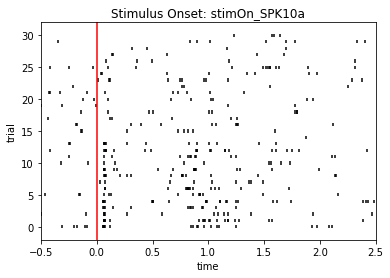

In [17]:
# example raster plot
aplot = channelSpikeRaster( a, 'stimOn_SPK10a' )

In [18]:
# subplots for multiple rasters
def multiChannel_rasterplot( data_df, channel ):
    """
    plot a subplot raster of trial spike data 
    for a given channel in data_df
    """
    neuralData = data_df[channel]      
    fig = plt.eventplot(neuralData, color='black', linelengths = 0.5)     
    plt.xlabel('time')
    ys = plt.gca().get_ylim()
    plt.text(-1.5, ys[1]/2, channel, fontsize=12)
    plt.axvline(x=0, c = 'red')
    plt.xlim( [-0.5,2.5])
    #plt.show()
    return fig

def multiChannel_stimOn_Rasters( data_df, **kwargs ):
    
    channelList = kwargs.get('channelList', None)
    
    if channelList:
        stimOnCols = channelList
    else:
        stimOnCols = getDataTypeNames( data_df, 'stimOn_' ).values.tolist()
        stimOnCols = [item for sublist in stimOnCols for item in sublist]
    
    fig = plt.subplots(figsize=(6, 20))
    plt.subplots_adjust( hspace = 0.1 )
    for count, channel in enumerate( stimOnCols ):
        plt.subplot(len( stimOnCols ),1,count + 1)
        multiChannel_rasterplot( a, channel )
    return fig

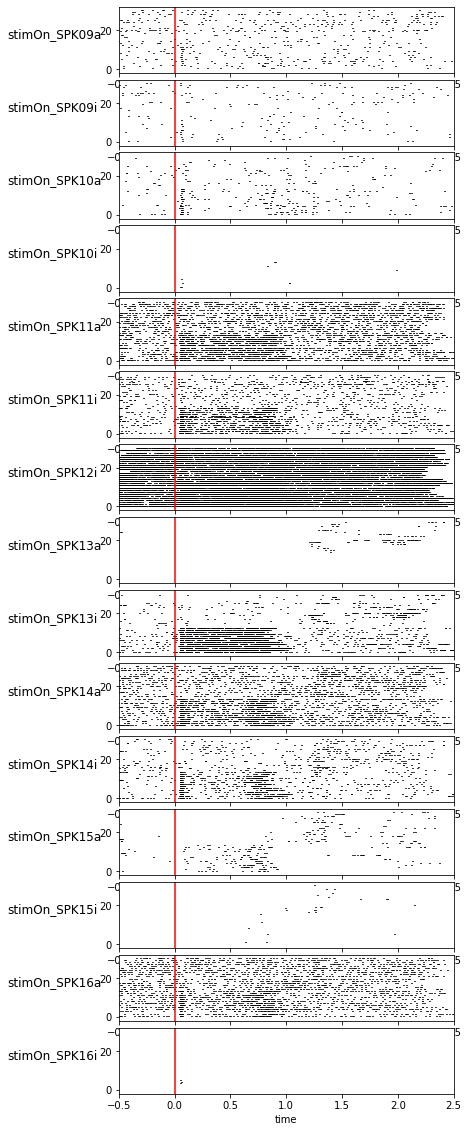

In [19]:
amultirast = multiChannel_stimOn_Rasters( a )
plt.show()

In [20]:
# a simple spike histogram
def channelSpikeHist( data_df, channel ):
    """
    plot a simple histogram of trial spike data 
    for a given channel in data_df
    """
    bins = np.arange(-0.5, 2.5, 0.05)
    neuralData = data_df[channel].sum()      
    fig = plt.hist(neuralData, bins, color = [0.5, 0.5, 0.5 ] )    
    plt.xlim([-0.5, 2.5])            
    plt.ylabel('Counts')             
    plt.title('stimOn_SPK10a')             
    plt.axvline(x=0, c = 'red')
    return fig

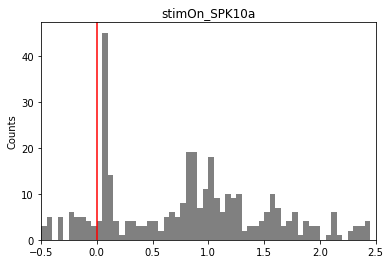

In [21]:
ahist = channelSpikeHist( a, 'stimOn_SPK10a' )
plt.show()

In [22]:
# subplots for multiple rasters
def multiChannel_histplot( data_df, channel ):
    """
    plot a subplot histogram of trial spike data 
    for a given channel in data_df
    """
    bins = np.arange(-0.5, 2.5, 0.05)
    neuralData = data_df[channel].sum()      
    fig = plt.hist(neuralData, bins, color = [0.5, 0.5, 0.5 ] )      
    plt.xlabel('time')
    ys = plt.gca().get_ylim()
    plt.text(-1.5, ys[1]/2, channel, fontsize=12)
    plt.axvline(x=0, c = 'red')
    plt.xlim( [-0.5,2.5])
    #plt.show()
    return fig

def multiChannel_stimOn_Histograms( data_df, **kwargs ):
    
    channelList = kwargs.get('channelList', None)
    
    if channelList:
        stimOnCols = channelList
    else:
        stimOnCols = getDataTypeNames( data_df, 'stimOn_' ).values.tolist()
        stimOnCols = [item for sublist in stimOnCols for item in sublist]
    
    plt.subplots(figsize=(6, 20))
    plt.subplots_adjust( hspace = 0.1 )
    for idx, channel in enumerate( stimOnCols ):
        plt.subplot(len( stimOnCols ),1,idx + 1)
        multiChannel_histplot( a, channel )
    plt.show()

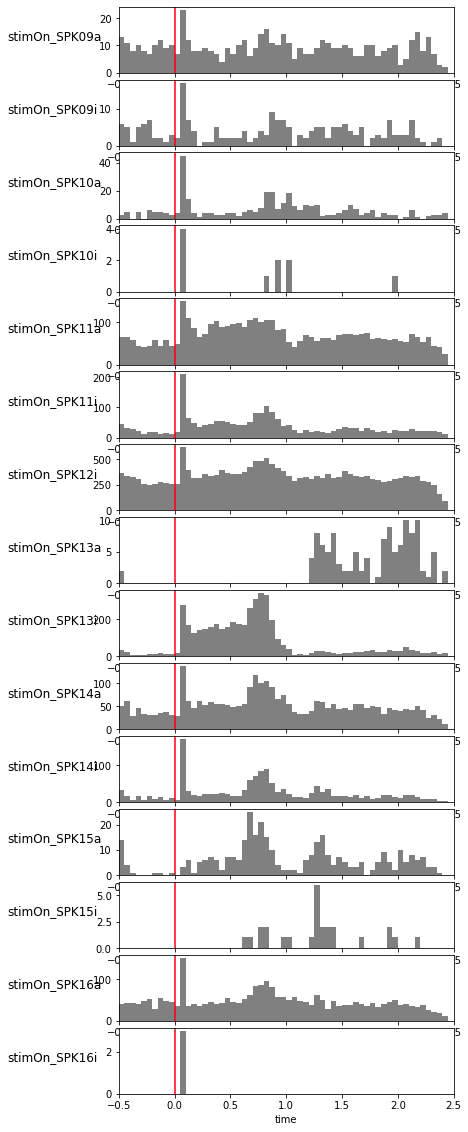

In [23]:
amultihist = multiChannel_stimOn_Histograms( a )
#plt.show()

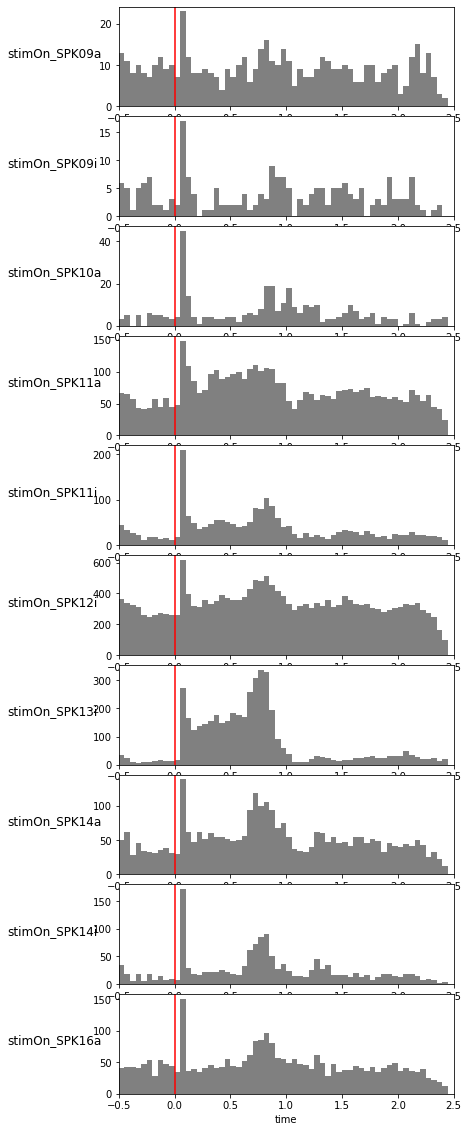

In [24]:
# can pass a custom list of channels to visualize only a selection
customList = ['stimOn_SPK09a', 'stimOn_SPK09i', 'stimOn_SPK10a', 'stimOn_SPK11a', 
              'stimOn_SPK11i', 'stimOn_SPK12i', 'stimOn_SPK13i', 'stimOn_SPK14a', 
              'stimOn_SPK14i', 'stimOn_SPK16a']

amultihist = multiChannel_stimOn_Histograms( a, channelList = customList )

(<Figure size 432x1440 with 10 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7eccbc8510>)

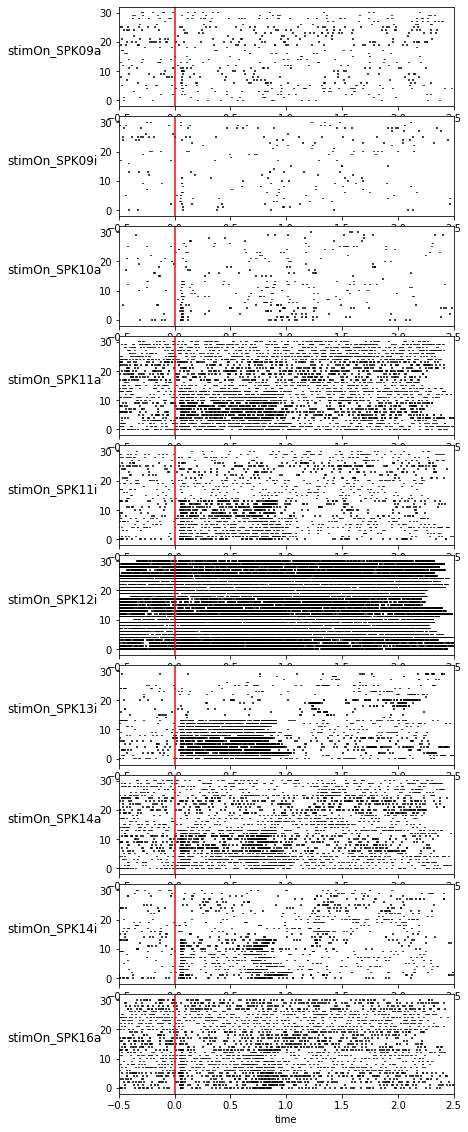

In [25]:
#same goes with rasters
multiChannel_stimOn_Rasters( a, channelList = customList )

<br>

### Loading `.bhv` files

<br>

In [27]:
#load .mat into python environment
bhvPath = "/home/bonzilla/Desktop/scienceLife/linArray/bhv_083018/180830_Peanut_delayedSaccadeTask_2016_6_8(1).mat"
bhvMat = loadmat( bhvPath )

In [28]:
print( type( bhvMat ) )
bhvMat.keys()

<class 'dict'>


dict_keys(['__header__', '__version__', '__globals__', 'MLConfig', 'Trial1', 'Trial2', 'Trial3', 'Trial4', 'Trial5', 'Trial6', 'Trial7', 'Trial8', 'Trial9', 'Trial10', 'Trial11', 'Trial12', 'Trial13', 'Trial14', 'Trial15', 'Trial16', 'Trial17', 'Trial18', 'Trial19', 'Trial20', 'Trial21', 'Trial22', 'Trial23', 'Trial24', 'Trial25', 'Trial26', 'Trial27', 'Trial28', 'Trial29', 'Trial30', 'Trial31', 'Trial32', 'Trial33', 'Trial34', 'Trial35', 'Trial36', 'Trial37', 'Trial38', 'Trial39', 'Trial40', 'Trial41', 'Trial42', 'Trial43', 'Trial44', 'Trial45', 'Trial46', 'Trial47', 'Trial48', 'Trial49', 'Trial50', 'Trial51', 'Trial52', 'Trial53', 'Trial54', 'Trial55', 'Trial56', 'Trial57', 'Trial58', 'Trial59', 'Trial60', 'Trial61', 'Trial62', 'Trial63', 'Trial64', 'Trial65', 'Trial66', 'Trial67', 'Trial68', 'Trial69', 'Trial70', 'Trial71', 'Trial72', 'Trial73', 'Trial74', 'Trial75', 'Trial76', 'Trial77', 'Trial78', 'Trial79', 'Trial80', 'Trial81', 'Trial82', 'Trial83', 'Trial84', 'Trial85', 'Trial8

In [29]:
#list of fields in .bhv struc

bhv_fields = [ 'Trial', 'Block', 'TrialWithinBlock', 'Condition', 'TrialError',
              'ReactionTime', 'AbsoluteTrialStartTime', 'TrialDateTime', 'BehavioralCodes',
              'AnalogData', 'ObjectStatusRecord', 'RewardRecord', 'UserVars', 
              'VariableChanges', 'TaskObject', 'CycleRate', 'Ver' ]

bhv_fields

['Trial',
 'Block',
 'TrialWithinBlock',
 'Condition',
 'TrialError',
 'ReactionTime',
 'AbsoluteTrialStartTime',
 'TrialDateTime',
 'BehavioralCodes',
 'AnalogData',
 'ObjectStatusRecord',
 'RewardRecord',
 'UserVars',
 'VariableChanges',
 'TaskObject',
 'CycleRate',
 'Ver']

In [126]:
# need the eye position, time, and eventmarker timestamps
Trial1_bhvdat = bhvMat[ 'Trial1' ]
#Trial1_bhvdat[0][0][9][0][0][1] #eye position
#Trial1_bhvdat[0][0][8][0][0] #strobed codes & code timestamps

#TrialRecord_bhvdat = bhvMat[ 'TrialRecord' ]
num = 8
print( bhv_fields[ num ] )
print( len(Trial1_bhvdat[0][0][num]) ) #
Trial1_bhvdat[0][0][num][0][0]

BehavioralCodes
1


(array([[   5.72920707],
       [   7.99208432],
       [  12.12556773],
       [  12.39137531],
       [  12.65484096],
       [  12.92006305],
       [ 159.58436829],
       [ 171.99740633],
       [ 189.79334047],
       [ 256.6336993 ],
       [ 392.40252868],
       [ 416.21894581],
       [ 433.6597868 ],
       [ 447.53096087],
       [ 969.40461153],
       [ 970.18095699],
       [ 970.45320484],
       [ 980.32028642],
       [1592.22542122],
       [1596.98068357],
       [2148.82882197],
       [2166.58318709],
       [2288.05022241],
       [2989.48391469],
       [3191.71927441],
       [3198.06762578],
       [3414.47216851]]), array([[   9],
       [5555],
       [2018],
       [ 830],
       [1608],
       [ 841],
       [   1],
       [  10],
       [  13],
       [  13],
       [  13],
       [  13],
       [  13],
       [  13],
       [   3],
       [  41],
       [ 555],
       [  30],
       [  46],
       [  40],
       [ 666],
       [  13],
       [  13],
    

In [124]:
# need some functions to move relevant data from the .mat structure to a pandas dataframe

def bhvmat2pandasdf( bhvmat ):
    """
    move data from a .mat file adaptation of a .bhv file 
    into a more human-friendly format as a pandas dataframe
    
    takes an input a .mat file returns a df
    """
     
    num_trials = bhvmat['TrialRecord'][0][0][0][0][0]
    trial_nums = list( range( 1,num_trials + 1 ) )
    trial_Labels = [ 'Trial' + str( trial_num ) for trial_num in trial_nums ]
    AbsTST = [ bhvmat[ trial_label ][0][0][6][0][0] for trial_label in trial_Labels ]
    Eyedat = [ bhvmat[ trial_label ][0][0][9][0][0][1] for trial_label in trial_Labels ]
    BHVCodes = [ bhvmat[ trial_label ][0][0][8][0][0] for trial_label in trial_Labels ]
        

    bhv_data = { 'Trial_Number':trial_nums,
                'Trial_Labels':trial_Labels,
                'AbsoluteTrialStartTime':AbsTST,
                'AnalogEyeData':Eyedat,
                'BehavioralCodes':BHVCodes }
    bhv_df = pd.DataFrame( bhv_data )
    
    return bhv_df

In [127]:
abhv_df = bhvmat2pandasdf( bhvMat )
abhv_df.head()
#len( bhvMat[ 'Trial1' ][0][0][9][0][0][1] )

,Trial_Number,Trial_Labels,AbsoluteTrialStartTime,AnalogEyeData,BehavioralCodes
0,1,Trial1,0.000000,"[[-22.09418424154145, 12.133549342766157], [-2...","[[[5.729207070544362], [7.992084319994319], [1..."
1,2,Trial2,3972.893775,"[[4.870643585723816, 1.62802326169313], [4.803...","[[[0.6545657888636924], [25.40921339459601], [..."
2,3,Trial3,7439.404802,"[[-23.81452333269965, 10.73779962997448], [-23...","[[[1.3199629393056966], [31.058502547239186], ..."
3,4,Trial4,11031.459556,"[[-2.7024497713135824, 6.48429058186654], [-2....","[[[0.27224784207646735], [11.224222445889609],..."
4,5,Trial5,12239.452226,"[[-26.411747511414376, 12.779056931449766], [-...","[[[0.2643438747327309], [12.681187527050497], ..."


In [161]:
#function to add feature collumns for a list of behavioral codes
def addEventcodeVariable( bhv_df, eventcode_list ):
    """
    for each number in eventcode_list,
    add a feature column to bhv_df with a list of times 
    corresponding to the code number
    """
    
    numtrials = bhv_df.shape[0]
    
    for trial in 
    eventnum = eventcode_list[ 0 ]
    res = bhv_df[ 'BehavioralCodes' ][0][1].tolist()
    res = [item for sublist in res for item in sublist]
    res = [i for i, x in enumerate(res) if x == eventnum]
    
    timevals = bhv_df[ 'BehavioralCodes' ][0][0].tolist()
    timevals = [item for sublist in timevals for item in sublist]
    timevals = timevals[ res[0] ]
    
    return res, timevals
    

In [162]:
addEventcodeVariable( abhv_df, [10, 30] )

([7], 171.99740632713656)

In [164]:
abhv_df.shape[0]

152

In [26]:
sample_rate = 1000
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

NameError: name 'samples' is not defined